# Машинное обучение, ВМК МГУ

## Практическое задание 4. Разложение ошибки на смещение и разброс. Градиентный бустинг ~~своими руками~~

### Общая информация

Дата выдачи: 30.11.2020 01:00

Мягкий дедлайн: 01:00MSK 14.12.2020

Жесткий дедлайн: 01:00MSK 21.12.2020

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-04-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями bootstraping для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston. 
Также в задании вам будет предложено пообучать готовые модели градиентного бустинга и CatBoost.

**Напоминание:**
    
* Все ваши графики должны быть **"красивыми"** --- подробнее о том, как их оформлять, можно найти в первом практическом задании. При несоответствии какиму-то из критериев вам могут снять баллы.
* Пишите в текстовых ячейках/print в коде ответы на **все вопросы из заданий/просьбы сделать выводы** --- при их отсутствии мы не можем понять, сделали ли вы задание и понимаете, что происходит, и поэтому будем снижать баллы

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from timeit import default_timer as timer
from copy import deepcopy
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import random
import seaborn as sns
from sklearn.datasets import load_boston
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from google.colab import drive
from sklearn.model_selection import train_test_split
from scipy.stats import mode
import warnings
import sys
import os
from contextlib import contextmanager
!pip install catboost
!pip uninstall lightgbm
!rm -r /opt/conda/lib/python3.6/site-packages/lightgbm
!git clone --recursive https://github.com/Microsoft/LightGBM
!apt-get install -y -qq libboost-all-dev

In [ ]:
%%bash
cd LightGBM
rm -r build
mkdir build
cd build
cmake -DUSE_GPU=1 -DOpenCL_LIBRARY=/usr/local/cuda/lib64/libOpenCL.so -DOpenCL_INCLUDE_DIR=/usr/local/cuda/include/ ..
make -j$(nproc)

In [ ]:
!cd LightGBM/python-package/;python3 setup.py install --precompile
!mkdir -p /etc/OpenCL/vendors && echo "libnvidia-opencl.so.1" > /etc/OpenCL/vendors/nvidia.icd
!rm -r LightGBM
import lightgbm as lgbm
import catboost as ctb
from sklearn.metrics import average_precision_score
warnings.simplefilter("ignore")
sns.set(style="darkgrid")
%matplotlib inline
drive.mount('/content/drive')

path = '/content/drive/MyDrive/5sem/mmp/mmro_report/hw4/'

## Часть 1. Bias-Variance Decomposition

In [ ]:
boston = load_boston()

X = boston["data"]
y = boston["target"]

In [ ]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [ ]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

33.7154846463232

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__Задание 1. (1.5 баллa)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [ ]:
def compute_biase_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    all_preds = np.empty((X.shape[0], num_runs))
    all_preds[:] = np.nan

    for num_run in range(num_runs):
        np.random.seed(num_run)
        ind = np.random.randint(low=0, high=X.shape[0], size=X.shape[0])
        oob = np.isin(range(X.shape[0]), ind) == False
        regressor_c = deepcopy(regressor)        # чтобы 2-ой fit не дообучал предыдущую модель
        regressor_c.fit(X[ind, :], y[ind])
        all_preds[oob, num_run] = regressor_c.predict(X[oob, :])
    
    nempty = np.any(np.isnan(all_preds) == False, axis=1)
    all_preds = all_preds[nempty, :]
    y_true = y[nempty]
    mean_preds = np.nanmean(all_preds, axis=1)
    bias = ((mean_preds - y_true) ** 2).mean()
    variance = (np.nanstd(all_preds, axis=1) ** 2).mean()
    error = np.nanmean(((all_preds - y_true.reshape(-1, 1)) ** 2), axis=1).mean()
    return bias, variance, error

**Задание 2. (0.5 баллa)**

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.


In [ ]:
algs = {
    'linreg': LinearRegression(),
    'dec_tree': DecisionTreeRegressor(),
    'rand_forest': RandomForestRegressor()
    }

print('{:>12}  {:>12}  {:>12}  {:>12}'.format('alg_name', 'bias', 'variance', 'error'))
for name, reg in algs.items():
    bias, variance, error = np.around(compute_biase_variance(reg, X, y), 2)
    print('{:>12}  {:>12}  {:>12}  {:>12}'.format(name, bias, variance, error))

    alg_name          bias      variance         error
      linreg         23.77          0.96         24.73
    dec_tree         10.32         13.04         23.35
 rand_forest         10.61           2.2         12.82


In [ ]:
RandomForestRegressor().n_estimators

100

Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на семинарах (с комментарием)?

__Your answer here:__ Да, результаты согласуются. Линейная модель простая, чтобы уловить сложность данных, следовательно, bias большой и variance маленький. Решающее дерево сложное, следовательно, bias маленький variance большой. Случайный лес - ансамблевый метод, если деревья относительно независимы, то variance уменьшается по сравнению с variance одного реш. дерева

Вспомните во сколько раз в теории бутстрап уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

__Your answer here:__ уменьшается в N (кол-во алгоритмов в общем случае, в данном случае кол-во деревьев) раз, если ответы алгроритмов независимы. Видно, что разброс уменьшился ~ x10 раз, но не в N == 100. Это связано с кореллированностью ответов деревьев.

### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__Задание 3. (1.5 балла)__

Реализуйте фукнцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [ ]:
def plot_predictions(regressor, X, y, ax, num_runs=100, num_test_objects=10, title=""):
    """
    plot graphics described above
    """
    indx = np.arange(X.shape[0])
    np.random.seed(42)
    np.random.shuffle(indx)
    test_ind = indx[:num_test_objects]
    train_ind = np.where(np.isin(range(X.shape[0]), test_ind) == False)[0]
    X_train, X_test, y_train, y_test = X[train_ind, :], X[test_ind, :], y[train_ind], y[test_ind]
    all_preds = np.zeros((y_test.shape[0], num_runs))
    for num_run in range(num_runs):
        ind = np.random.randint(low=0, high=X_train.shape[0], size=X_train.shape[0])
        regressor_c = deepcopy(regressor)        # чтобы 2-ой fit не дообучал предыдущую модель
        regressor_c.fit(X_train[ind, :], y_train[ind])
        all_preds[:, num_run] = regressor_c.predict(X_test)
    
    nums = np.arange(y_test.shape[0])
    ax.scatter(np.tile(nums.reshape(1, -1), (num_runs, 1)).T.ravel(), all_preds.ravel())
    ax.scatter(nums, y_test, c='black')
    
    ax.set_title(title)
    ax.set_xlabel('Номер объекта тестовой выборки')
    ax.set_ylabel('Предсказание')
    return ax

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

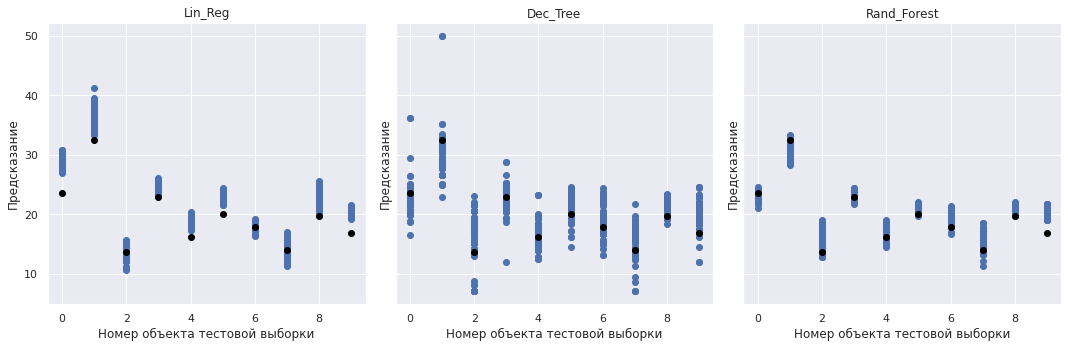

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharey=True)

plot_predictions(LinearRegression(), X, y, ax=axs[0], title='Lin_Reg')
plot_predictions(DecisionTreeRegressor(), X, y, ax=axs[1], title='Dec_Tree')
plot_predictions(RandomForestRegressor(), X, y, ax=axs[2], title='Rand_Forest')
# axs[0].set(xlabel='x', ylabel='y', title='This is our custom plot on the specified axs')

plt.tight_layout()
plt.show()

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма.

**Your answer here:**  
Lin_Reg
* смещение относительно большое (недообучили, модель слишком проста)
* разброс средний  

Dec_Tree
* смещение относительно малое
* разброс большой (переобучили)

Rand_Forest (лучше результат, т.к. еще сэмплируем признаки)
* смещение относительно малое
* разброс малый

### Часть 2. Градиентный бустинг

**Задание 4 (1 балл)**

Мы будем использовать данные из [соревнования](https://www.kaggle.com/t/b710e05dc0bd424995ca94da5b639869) (вам нужны только данные, посылать туда ничего не надо).
* Загрузите таблицу application_train.csv;
* Запишите в Y столбец с целевой переменной (TARGET);
* Удалите ненужные столбцы:
    * Воспользуйтесь описанием соревнования
    * При желании, воспользуйтесь методами feature selection/стат. методами, если хотите. Объясните, что использовали и почему решили выкинуть тот или иной признак.
* Определите тип столбцов и заполните пропуски - стратегия произвольная;
* Разбейте выборку в соотношении 70:30 с random_state=0. Если считаете нужным, сделайте сбалансированное по классам разбиение.

Так как в данных имеется значительный дисбаланс классов, в качестве метрики качества везде будем использовать площадь под precision-recall кривой (AUC-PR).

In [11]:
dt = pd.read_csv(path + 'application_train.csv')
desc = pd.read_csv(path + 'desc.csv', encoding = 'ISO-8859-1')
X = dt.drop(columns=['TARGET'])
y = dt['TARGET']

Я исходил при отоборе при селекции признаков из того, как признак может помочь релевантно разделить людей на классы  

**Number of enquiries to Credit Bureau about the client** - взял только за месяц и за год, т.к. остальные диапозоны либо слишком маленькие, либо являются промежуточными  
**How many observation of client's social surroundings defaulted on 30/60 (days past due) DPD** - есть похожие признаки за 30/60 дней, а не на 30/60 день  
**On which day of the week did the client apply for the loan** - не вижу особой закономерности, связанной с разделением на классы  
**Approximately at what hour did the client apply for the loan** - заменил на бинарный признак (с 7 утра до 2 часов ночи - 0, иначе - 1), сегментировать на группы людей  
**FLAG_MOBIL** - они у всех есть  
**Gender of the client** - в принципе этот признак можно было и оставить, т.к. мужчины более толерантны к риску и следовательно это может помочь разделить классы. Но существует феминизм, поэтому уберём признак    
**ID of loan in our sample**  




In [12]:
indx_dropc = [0]
descr_columns = list(desc[desc['Table'] == 'application_{train|test}.csv']['Description'].values)
col_id = descr_columns.index('Approximately at what hour did the client apply for the loan') - 1
column_name_drop = [
    'Number of enquiries to Credit Bureau about the client 3 month before application (excluding one month before application)',
    'Number of enquiries to Credit Bureau about the client one hour before application',
    'Number of enquiries to Credit Bureau about the client one day before application (excluding one hour before application)',
    'Number of enquiries to Credit Bureau about the client one week before application (excluding one day before application)',
    "How many observation of client's social surroundings defaulted on 30 DPD (days past due) ",
    "How many observation of client's social surroundings defaulted on 60 (days past due) DPD",
    "On which day of the week did the client apply for the loan",
    'Did client provide mobile phone (1=YES, 0=NO)',
    'Gender of the client'
]
for column_name in column_name_drop:
    indx_dropc.append(descr_columns.index(column_name) - 1)

X.iloc[:, col_id][(X.iloc[:, col_id] >= 7) | (X.iloc[:, col_id] < 2)] = 0
X.iloc[:, col_id][X.iloc[:, col_id] != 0] = 1
X.drop(columns=X.columns[indx_dropc], inplace=True)

In [13]:
X.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215257 entries, 0 to 215256
Data columns (total 111 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   NAME_CONTRACT_TYPE            object 
 1   FLAG_OWN_CAR                  object 
 2   FLAG_OWN_REALTY               object 
 3   CNT_CHILDREN                  int64  
 4   AMT_INCOME_TOTAL              float64
 5   AMT_CREDIT                    float64
 6   AMT_ANNUITY                   float64
 7   AMT_GOODS_PRICE               float64
 8   NAME_TYPE_SUITE               object 
 9   NAME_INCOME_TYPE              object 
 10  NAME_EDUCATION_TYPE           object 
 11  NAME_FAMILY_STATUS            object 
 12  NAME_HOUSING_TYPE             object 
 13  REGION_POPULATION_RELATIVE    float64
 14  DAYS_BIRTH                    int64  
 15  DAYS_EMPLOYED                 int64  
 16  DAYS_REGISTRATION             float64
 17  DAYS_ID_PUBLISH               int64  
 18  OWN_CAR_AGE            

In [14]:
def replace_nan(column_series):
    if column_series.dtype == np.float64:
        fill_v = np.nanmean(column_series)
    else:
        fill_v = mode(column_series)[0][0]
    return pd.Series(column_series).fillna(fill_v)

count_nan = X.isna().sum(axis=0)
indx_col_nan = np.where(count_nan.values != 0)[0]
for indx_col in indx_col_nan:
    X.iloc[:, indx_col] = replace_nan(X.iloc[:, indx_col])

In [15]:
np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

**Задание 5 (1 балл)**

Обучите реализации градиентного бустинга LightGBM и Catboost на вещественных признаках без подбора параметров. **Получилась ли заметная разнциа в качестве? Как вы думаете, почему?**

**Замечание:**
* В этом и последующих экспериментах необходимо измерять время обучения моделей.

In [16]:
col_types = X.dtypes.values
rel_f = np.where([el_t == np.float64 or el_t == np.int64 for el_t in col_types])[0]

In [ ]:
times = []
scores = []
algs = {
    'cpu_lgbm': lgbm.LGBMClassifier(),
    'cpu_ctb': ctb.CatBoostClassifier(),
    'gpu_lgbm': lgbm.LGBMClassifier(device='gpu'),
    'gpu_ctb': ctb.CatBoostClassifier(task_type="GPU")
}

print('{:>12}  {:>12}  {:>12}'.format('alg', 'score', 'time (c)'))
ind = 0
for name, clf in algs.items():
    start = timer()
    clf.fit(X_train.iloc[:, rel_f], y_train, verbose=False)
    score = np.around(average_precision_score(y_test, clf.predict_proba(X_test.iloc[:, rel_f])[:, 1]), 3)
    end = timer()
    t_sec = np.around(end - start, 1)
    scores.append(score)
    times.append(t_sec)
    ind += 1
    if ind == 3:
        print('\n')
    print('{:>12}  {:>12}  {:>12}'.format(name, score, t_sec))

         alg         score      time (c)
    cpu_lgbm         0.238           5.2
     cpu_ctb         0.236          74.9


    gpu_lgbm         0.238           3.6
     gpu_ctb         0.241          11.7


**Your answer here:** Разница есть. Скорее всего из-за большого различия кол-ва деревьев (100 vs 1000). Время значительно меньше в gpu и качество лучше -> будем находить оптимальные параметры через gpu

__Задание 6. (2 балла)__

Подберите оптимальные с точки зрения метрики качества параметры алгоритмов, изменяя:

* глубину деревьев;
* количество деревьев;
* темп обучения;
* оптимизируемый функционал.

Масштаб значений предлагается посмотреть [тут](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/seminars/sem10-gbm.ipynb).

**Проанализируйте соотношения получившихся оптимальных глубины и количества деревьев в зависимости от алгоритма.** 

**Если на перебор гиперпараметров уходит много времени, то переберите значениях каких-нибудь 1-2 гиперпараметров, а не всех предложенных 4**

In [17]:
@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

In [ ]:
grid_params={
    'learning_rate': np.logspace(-4, 0, 100),
    'max_depth':  list(range(1,16)),
    'n_estimators': list(range(10, 1000)),
    'random_state': [0],
}
gpu_params = {
    'lgbm': {
        'device': 'gpu',
        'verbose': -1,
    },
    'ctb': {
        'task_type': "GPU",
        'verbose': False
    }
}
algs = {
    'lgbm': lgbm.LGBMClassifier(**gpu_params['lgbm']),
    'ctb': ctb.CatBoostClassifier(**gpu_params['ctb'])
}
sch = {
    'lgbm': RandomizedSearchCV,
    'ctb': RandomizedSearchCV
}

n_iter = 10
aps = make_scorer(average_precision_score, needs_proba=True)

print('{:>16}  {:>16}  {:>16}  {:>16}  {:>16}  {:>16}'.format('alg',
                                                              'lr',
                                                              'max_depth',
                                                              'n_estimators',
                                                              'score',
                                                              'time (c)'))
for name, clf in algs.items():
    cur_rs=RandomizedSearchCV(clf,
                              grid_params,
                              n_iter = n_iter,
                              scoring=aps,
                              cv=5,
                              verbose=False,
                              random_state=0)

    start = timer()
    with suppress_stdout():                         # can't suppress warnings with verbose=-1
        cur_rs.fit(X_train.iloc[:, rel_f], y_train)
    score = np.around(average_precision_score(y_test, cur_rs.predict_proba(X_test.iloc[:, rel_f])[:, 1]), 3)
    end = timer()
    t_sec = np.around(end - start, 0)
    sch[name] = cur_rs
    print('{:>16}  {:>16}  {:>16}  {:>16}  {:>16}  {:>16}'.format(name,
                                                                  np.around(cur_rs.best_params_['learning_rate'], 4),
                                                                  cur_rs.best_params_['max_depth'],
                                                                  cur_rs.best_params_['n_estimators'],
                                                                  score, 
                                                                  t_sec))

             alg                lr         max_depth      n_estimators             score          time (c)
            lgbm            0.0385                14               135             0.239             372.0
             ctb            0.4751                 2               383             0.236            1747.0


<<time (c)>> - время подбора параметров

In [ ]:
clf = lgbm.LGBMClassifier(**sch['lgbm'].best_params_, **gpu_params['lgbm'])
start = timer()
with suppress_stdout():                         # can't suppress warnings with verbose=-1
    clf.fit(X_train.iloc[:, rel_f], y_train)
end = timer()
print ('Lgbm best model time: ', str(np.around(end - start, 1)) + ' c')
clf = ctb.CatBoostClassifier(**sch['ctb'].best_params_, **gpu_params['ctb'])
start = timer()
with suppress_stdout():                         # can't suppress warnings with verbose=-1
    clf.fit(X_train.iloc[:, rel_f], y_train)
end = timer()
print ('Ctb best model time: ', str(np.around(end - start, 1)) + ' c')

Lgbm best model time:  4.1 c
Ctb best model time:  3.9 c


**Your answer here:** Заметим, что logloss является единственным походящим этой задаче параметром для задания оптимизируемого функционала.  
Lgbm строит мало деревьев но большой глубины, т.е. объединяет модели с малым bias и большим variance. Catboost же, наоборот, строит модели с большим bias и малым variance.   
Большой lr у ctb можно аргументировать большим количеством моделей. Если он был меньше, то был бы меньший эффект от большого количества деревьев. 

**Задание 7 (1.5 баллa)**

Добавьте категориальные признаки к вещественным следующими способами:

* как OHE признаки;
* как счетчики со сглаживанием.

Можно использовать библиотечные реализации; при подсчете счетчиков нельзя использовать циклы.

Как меняется время, необходимое для обучения моделей в зависимости от способа кодирования? (Параметры можно не подбирать).

In [18]:
def one_h_enc(data, columns, uniq_val=None, mean_t_info=None):        # фиктивные переменные добавил, чтобы кода в клетке ниже было меньше 
    aug_data = deepcopy(data)
    for column in columns:
        if uniq_val is None:
            uniq = pd.unique(data[column])
        else:
            uniq = uniq_val[column]
        ind = 0
        for val in uniq:
            aug_data[column + '_' + str(ind)] = (aug_data[column] == val).astype(int).values
            ind += 1
    aug_data.drop(columns=columns, inplace=True)
    return aug_data

def smooth_enc(data, columns, uniq_val=None, mean_t_info=None):
    tdata = pd.concat([mean_t_info['data'], pd.DataFrame(data=mean_t_info['y'].values,
                                                         index=mean_t_info['y'].index,
                                                         columns=['target'])], axis=1)
    mdata = deepcopy(data)
    m_y = mean_t_info['y'].mean()
    std_y = mean_t_info['y'].std()
    c = 10

    for col in columns:
        gr = tdata.groupby(col).agg(['mean', 'count', 'std'])
        mean = gr[('target',  'mean')]
        count = gr[('target',  'count')]
        std = gr[('target',  'std')]
        prior = np.random.uniform()

        map_values = (mean * count + c * prior) / (count + c)
        mdata[col + '_smooth'] = mdata[col].map(map_values).fillna(m_y)
        temp = mdata[col].map(std).fillna(std_y)
        temp.apply(lambda x: np.random.normal(0, x))

        mdata.loc[:, col + '_smooth'] += temp 
        
        mdata[col + '_smooth'][mdata[col + '_smooth'] < 0] = 0
        mdata[col + '_smooth'][mdata[col + '_smooth'] > 1] = 1
    mdata.drop(columns=columns, inplace=True)
    return mdata

In [19]:
n_uniq = X_train.nunique().sort_values(ascending=True)
n_uniq.name = 'count_uniq'
type_d = pd.Series(index=n_uniq.index, data=n_uniq.index.map(X_train.dtypes).values, name='type')
column_info = pd.concat([n_uniq.to_frame(),
                         type_d.to_frame()], axis=1)
column_info = column_info.reset_index()
pre_cat_f = list(column_info[(column_info['index'].str.contains('CNT|AMT|MODE|OBS|MEDI|AGE') == False) \
                             | (column_info['count_uniq'] <= 10)]['index'])
indx = pre_cat_f.index('ORGANIZATION_TYPE')
cat_f = pre_cat_f[:indx+1]
cat_f.remove('REGION_RATING_CLIENT')
cat_f.remove('REGION_RATING_CLIENT_W_CITY')

In [ ]:
enc = {
    'ohe': one_h_enc,
    'smooth_enc': smooth_enc
}
algs = {
    'lgbm': lgbm.LGBMClassifier(**sch['lgbm'].best_params_, **gpu_params['lgbm']),
    'ctb': ctb.CatBoostClassifier(**sch['ctb'].best_params_, **gpu_params['ctb'])
}

print('{:>12}  {:>12}  {:>12}'.format('enc', 'score', 'time (c)'))
uniq = dict([(col, pd.unique(X_train[col])) for col in cat_f])
mean_info = {
    'data': X_train,
    'y': y_train
}
for name, clf in algs.items():
    print(name)
    for name, enc_f in enc.items():
        mX_train = enc_f(X_train, cat_f, uniq, mean_info)
        mX_test = enc_f(X_test, cat_f, uniq, mean_info)
        start = timer()
        with suppress_stdout():
            clf.fit(mX_train, y_train)
        score = np.around(average_precision_score(y_test, clf.predict_proba(mX_test)[:, 1]), 4)
        end = timer()
        t_sec = np.around(end - start, 1)
        print('{:>12}  {:>12}  {:>12}'.format(name, score, t_sec))

         enc         score      time (c)
lgbm
         ohe        0.2423           6.0
  smooth_enc        0.2431           5.2
ctb
         ohe        0.2398           4.4
  smooth_enc        0.2393           4.1


Для Lgbm время увеличилось как в случае ohe, так и в случае smooth_enc. Логично, что ohe будем занимать больше времени.  
Для Catboost - аналогично

**Задание 8 (1 балл)**

Для CatBoost можно не делать ручную обработку категориальных признаков, а подавать как есть. Обучите модель CatBoost, не обрабатывая специально категориальные признаки, замерьте время обучения (параметры возьмите из предыдущего пункта).  Сравните с временем обучения модели CatBoost из предыдущего пункта. Как изменилось время? Почему?

In [ ]:
times = []
scores = []
algs = {
    'ctb': ctb.CatBoostClassifier(**sch['ctb'].best_params_, **gpu_params['ctb'])
}

print('{:>12}  {:>12}  {:>12}'.format('alg', 'score', 'time (c)'))
for name, clf in algs.items():
    start = timer()
    with suppress_stdout():
        clf.fit(X_train, y_train, verbose=False, cat_features=cat_f)
    score = np.around(average_precision_score(y_test, clf.predict_proba(X_test)[:, 1]), 4)
    end = timer()
    t_sec = np.around(end - start, 1)
    scores.append(score)
    times.append(t_sec)
    print('{:>12}  {:>12}  {:>12}'.format(name, score, t_sec))

         alg         score      time (c)
         ctb        0.2388          10.4


Время обучения увеличилось. Статистика вычисляется для всех категориальных признаков. Это занимает больше времени, чем использование ohe.

**Бонус. (1 балл)**

Подберите оптимальные параметры для LightGBM с вещественными и категориальными признаками (предварительно обработанные каким-нибудь способом). Подберите оптимальные параметры для CatBoost с вещественными и необработанными категориальными признаками. Сравните качество моделей на наилучших параметрах. Какой метод получился лучше с точки зрения качества? Совпадает ли результат с вашими ожиданиями?

In [20]:
grid_params={
    'learning_rate': np.logspace(-4, 0, 100),
    'max_depth':  list(range(1,16)),
    'n_estimators': list(range(10, 1000)),
    'random_state': [0],
}
gpu_params = {
    'lgbm': {
        'device': 'gpu',
        'verbose': -1,
    },
    'ctb': {
        'task_type': "GPU",
        'verbose': False
    }
}
algs = {
    'lgbm': lgbm.LGBMClassifier(**gpu_params['lgbm']),
    'ctb': ctb.CatBoostClassifier(**gpu_params['ctb'])
}
sch = {
    'lgbm': RandomizedSearchCV,
    'ctb': RandomizedSearchCV
}
uniq = dict([(col, pd.unique(X_train[col])) for col in cat_f])
mean_info = {
    'data': X_train,
    'y': y_train
}

In [23]:
sch = {
    'lgbm': RandomizedSearchCV,
    'ctb': RandomizedSearchCV
}
algs = {
    'lgbm': lgbm.LGBMClassifier(**gpu_params['lgbm']),
    'ctb': ctb.CatBoostClassifier(**gpu_params['ctb'])
}
data = {
    'lgbm': (smooth_enc(X_train, cat_f, uniq, mean_info),
             smooth_enc(X_test, cat_f, uniq, mean_info),
             y_train,
             y_test),
    'ctb': (X_train,
            X_test,
            y_train,
            y_test)
}
grid_params={
    'learning_rate': np.logspace(-4, 0, 100),
    'max_depth':  list(range(1,16)),
    'n_estimators': list(range(10, 1000)),
    'random_state': [0],
}
n_iter = 10
aps = make_scorer(average_precision_score, needs_proba=True)

print('{:>16}  {:>16}  {:>16}  {:>16}  {:>16}  {:>16}'.format('alg',
                                                              'lr',
                                                              'max_depth',
                                                              'n_estimators',
                                                              'score',
                                                              'time (c)'))
for name, mclf in algs.items():
    cur_rs=RandomizedSearchCV(mclf,
                              grid_params,
                              n_iter = n_iter,
                              scoring=aps,
                              cv=3,
                              verbose=False,
                              random_state=0)

    start = timer()
    X_train, X_test, y_train, y_test = data[name]
    with suppress_stdout():                         # can't suppress warnings with verbose=-1
        if name == 'ctb':
            cur_rs.fit(X_train, y_train, cat_features=cat_f)
        else:
            cur_rs.fit(X_train, y_train)
    score = np.around(average_precision_score(y_test, cur_rs.predict_proba(X_test)[:, 1]), 4)
    end = timer()
    t_sec = np.around(end - start, 0)
    sch[name] = cur_rs
    print('{:>16}  {:>16}  {:>16}  {:>16}  {:>16}  {:>16}'.format(name,
                                                                  np.around(cur_rs.best_params_['learning_rate'], 4),
                                                                  cur_rs.best_params_['max_depth'],
                                                                  cur_rs.best_params_['n_estimators'],
                                                                  score, 
                                                                  t_sec))

             alg                lr         max_depth      n_estimators             score          time (c)
            lgbm            0.0385                14               135            0.2449             228.0
             ctb            0.4751                 2               383            0.2388            3692.0


С точки зрения качества выиграл Lgbm. С моими ожиданиями совпадает

**Бонус (0.2 балла)**

Вставьте лучший мем 2020

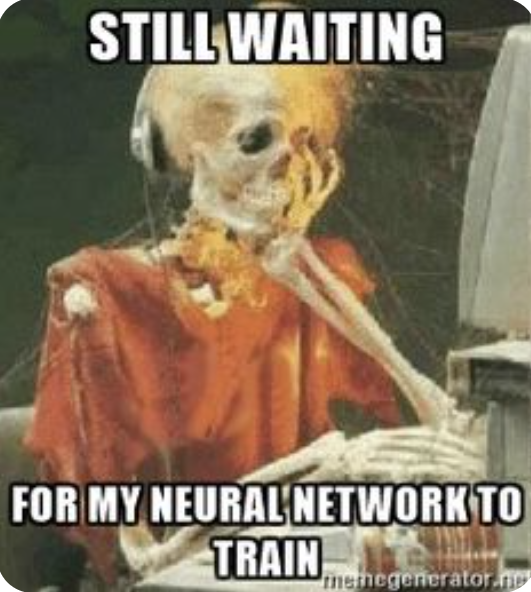

https://stackoverflow.com/questions/18794390/how-to-get-the-index-of-numpy-random-choice-python
https://www.machinelearningmastery.ru/all-about-categorical-variable-encoding-305f3361fd02/